In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import RidgeClassifier
from sklearn.kernel_approximation import RBFSampler

from sklearn.linear_model import RidgeClassifier

import matplotlib.pyplot as plt

import time

In [2]:
from lightonml.datasets import FashionMNIST

In [5]:
import pandas as pd

In [3]:
# import os

# os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [12]:
active_pixels = train_data_bin.sum(axis=1, keepdims=True)

In [105]:
opu_features_400_train = np.load('fashion_mnist_features_opu/exposure_500/no_dummy/train_100K.npy')

In [17]:
opu_features_400_test = np.load('fashion_mnist_features_opu/exposure_700/no_dummy/test_100K.npy')

In [106]:
raw_scale = (opu_features_400 / active_pixels).mean(axis=1).mean(axis=0)

In [107]:
raw_scale

0.0889688902844589

In [ ]:
opu_features_400

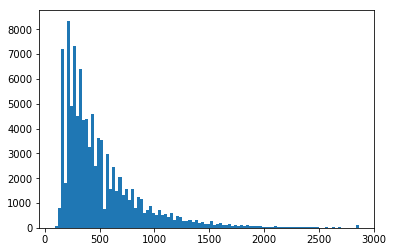

In [108]:
plt.hist(opu_features_400_train[1] / raw_scale, bins=100)
plt.show()

In [83]:
np_projection.shape

(70000, 1000)

In [95]:
raw_scale_np = (np_projection[:60000] / active_pixels).mean(axis=1).mean(axis=0)

In [96]:
raw_scale_np

0.035247306920411114

In [97]:
1/np.sqrt(784)

0.03571428571428571

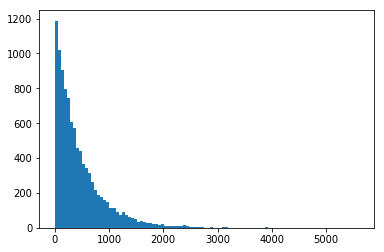

In [100]:
plt.hist(np_projection[1] / raw_scale_np, bins=100)
plt.show()

## Loading the data

In [76]:
(train_data, train_labels), (test_data, test_labels) = FashionMNIST()

# train_data = np.load('../datasets/export/fashion_mnist/numpy/train_data_fashion_mnist.npy').astype('uint8')
# test_data = np.load('../datasets/export/fashion_mnist/numpy/test_data_fashion_mnist.npy').astype('uint8')
# train_labels = np.load('../datasets/export/fashion_mnist/numpy/train_targets_fashion_mnist.npy').astype('uint8')
# test_labels = np.load('../datasets/export/fashion_mnist/numpy/test_targets_fashion_mnist.npy').astype('uint8')

# Convert one-hot to integers
# train_labels = np.argmax(train_labels, axis=1)
# test_labels = np.argmax(test_labels, axis=1)

D = train_data[0].reshape(-1).shape[0]

# Flatten the images
train_data = train_data.reshape(-1, D)
test_data = test_data.reshape(-1, D)

In [77]:
def threshold_binarize(data, threshold):
    data_bin = np.where(data>threshold, 1, 0).astype('uint8')
    return data_bin

In [78]:
# fashion mnist has values between 0 and 255
threshold = 10

train_data_bin = threshold_binarize(train_data, threshold)
test_data_bin = threshold_binarize(test_data, threshold)

## OPU Projection

In [7]:
from lightonml.projections.sklearn import OPUMap

In [2]:
?? OPUMap

In [4]:
?? OPU

In [7]:
n_components = 1000 # number of random projections
random_mapping = OPUMap(n_components=n_components, ndims=1)

In [7]:
dir(random_mapping.opu)

['_OPU__check_booking',
 '_OPU__opu_config',
 '_OPU__transform',
 '_TransformSetup',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_allowed_roi',
 '_cam_roi',
 '_count_ones',
 '_dmd_roi',
 '_max_n_features',
 '_min_batch_size',
 '_min_components',
 '_n_components',
 '_n_count',
 '_n_samples_by_pass',
 '_print',
 '_projection_times',
 '_resize_rnd_matrix',
 'batch_transform',
 'close',
 'device',
 'dmd_strategy',
 'features_fmt',
 'is_simulated',
 'max_n_components',
 'max_n_features',
 'n_components',
 'n_samples_by_pass',
 'open',
 'transform',
 'transform1d',
 'transform2d',
 'verbose',
 'version']

In [8]:
random_mapping.opu._max_n_features

1039680

In [10]:
random_mapping.opu._cam_roi.allowed_roi

[[960, 0], [960, 1080]]

In [8]:
random_mapping.opu.device.exposure_us

400

In [17]:
random_mapping.opu.device.frametime_us

500

In [18]:
random_mapping.opu.device.cam_ROI

([1270, 348], [341, 384])

In [15]:
dir(random_mapping.opu.device)

['_OpuDevice__opu',
 '__class__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cam_ROI_off',
 '_cam_roi_increment',
 '_cam_shape_max',
 '_cam_strategy',
 '_exposure_us_off',
 '_frametime_us_off',
 '_gain_dB_off',
 '_reserved_off',
 '_sequence_nb_prelim',
 'acquire_seq',
 'acquiring',
 'active',
 'cam_ROI',
 'cam_readout_us',
 'cam_roi_increment',
 'cam_roi_strategy',
 'cam_shape',
 'cam_shape_max',
 'close',
 'dmd_shape',
 'exposure_us',
 'fill_dmd',
 'frametime_us',
 'gain_dB',
 'input_size',
 'nb_features',
 'open',
 'opu_type',
 'reserve',
 'transform1',
 'transform2',
 'transform_single',
 'verbose',
 'versions']

## Good exp distribution

In [79]:
class OPUModuleNumpy(object):
    def __init__(self, input_features, output_features, activation=None, bias=False, initial_log_scale='auto', dtype='float32'):
        super(OPUModuleNumpy, self).__init__()
        
        self.real_matrix = np.random.normal(loc=0.0, scale=np.sqrt(0.5), size=(input_features, output_features)).astype(dtype)
        self.img_matrix = np.random.normal(loc=0.0, scale=np.sqrt(0.5), size=(input_features, output_features)).astype(dtype)
        
        if bias:
            self.bias = np.random.uniform(low=0.0, high=2 * np.pi, size=(1, output_features))
        else:
            self.bias = None
            
        self.activation = activation
        
        if initial_log_scale == 'auto':
            self.log_scale = -0.5 * np.log(input_features)
        else:
            self.log_scale = initial_log_scale
        
    def project(self, data, matrix):
        return np.dot(data, matrix)
        
    def forward(self, data):
        out_real = self.project(data, self.real_matrix) ** 2
        out_img = self.project(data, self.img_matrix) ** 2
        
        output = (out_real + out_img)
        if self.bias is not None:
            output += self.bias
        if self.activation is not None:
            output = self.activation(output)

        return np.exp(self.log_scale) * output

In [93]:
opm = OPUModuleNumpy(784, 10000)

In [94]:
np_projection = opm.forward(np.vstack([train_data_bin, test_data_bin]))

In [26]:
from scipy.stats import expon

In [31]:
expon.pdf(x, scale=1/exp_mean)

array([1.60288773e+001, 7.22381549e-008, 3.25559360e-016, 1.46721489e-024,
       6.61237185e-033, 2.98003119e-041, 1.34302579e-049, 6.05268249e-058,
       2.72779314e-066, 1.22934838e-074, 5.54036677e-083, 2.49690522e-091,
       1.12529295e-099, 5.07141487e-108, 2.28556029e-116, 1.03004506e-124,
       4.64215635e-133, 2.09210417e-141, 9.42859207e-150, 4.24923145e-158,
       1.91502271e-166, 8.63053007e-175, 3.88956480e-183, 1.75292992e-191,
       7.90001824e-200, 3.56034133e-208, 1.60455710e-216, 7.23133894e-225,
       3.25898423e-233, 1.46874297e-241, 6.61925850e-250, 2.98313483e-258,
       1.34442452e-266, 6.05898623e-275, 2.73063408e-283, 1.23062872e-291,
       5.54613695e-300, 2.49950569e-308, 1.12646513e-316, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0

In [32]:
len(np_projection[1])

1000

(array([0.07667223, 0.05055312, 0.05223821, 0.04971056, 0.04297016,
        0.03370207, 0.0387574 , 0.03285952, 0.03707228, 0.03454463,
        0.02527656, 0.02527656, 0.01853614, 0.02527656, 0.0210638 ,
        0.01600849, 0.01853614, 0.01432338, 0.01432338, 0.01937869,
        0.0126383 , 0.01516593, 0.01516593, 0.00589786, 0.01011062,
        0.00758297, 0.00926807, 0.01263828, 0.00674041, 0.00674041,
        0.00421276, 0.00421276, 0.00674041, 0.00674041, 0.00505531,
        0.00505531, 0.00421276, 0.00421276, 0.0016851 , 0.00674041,
        0.0016851 , 0.0016851 , 0.00252766, 0.0016851 , 0.0016851 ,
        0.00337021, 0.00337022, 0.00421276, 0.0016851 , 0.00252766,
        0.0016851 , 0.0016851 , 0.0016851 , 0.0016851 , 0.00168511,
        0.        , 0.00337022, 0.        , 0.00084255, 0.        ,
        0.        , 0.00084255, 0.00084255, 0.        , 0.00084255,
        0.        , 0.        , 0.00084255, 0.        , 0.        ,
        0.        , 0.00084255, 0.        , 0.  

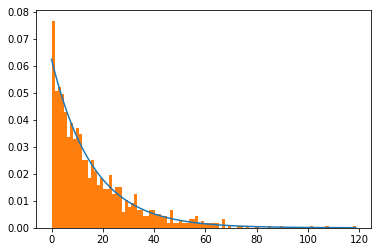

In [44]:
exp_mean = np_projection[1].mean()
x = np.linspace(0, np_projection[1].max(), num=100)

plt.plot(x, expon.pdf(x, scale=exp_mean))
plt.hist(np_projection[1], bins=100, normed=True)

In [66]:
import pandas as pd
import os
train_random_features = np.load(os.path.join('fashion_mnist_features_opu', 'exposure_400', 'no_dummy', 'train_100K.npy')).astype('float32')

In [10]:
train_random_features.head()

,activation,alpha,dummy_input,exposure_us,inversion_warning,output_dim,seed,test_score,training_time
0,NaN,0.0,0.0,1000.0,0.0,10.0,0.0,0.5493,0.030739
1,NaN,0.0,0.0,1000.0,0.0,10.0,1.0,0.5510,0.029758
2,NaN,0.0,0.0,1000.0,0.0,10.0,2.0,0.5677,0.028203
3,NaN,0.0,0.0,1000.0,0.0,10.0,3.0,0.5267,0.027017
4,NaN,0.0,0.0,1000.0,0.0,10.0,4.0,0.5469,0.027806


(array([8.06451762e-04, 7.17741792e-03, 3.13709735e-02, 3.26209612e-02,
        3.37096836e-02, 2.36290366e-02, 3.47580442e-02, 1.89919390e-02,
        2.60080693e-02, 2.43951658e-02, 1.23387120e-02, 1.29032282e-02,
        1.47177220e-02, 1.13709698e-02, 1.50403254e-02, 7.90322727e-03,
        1.07661310e-02, 6.45161409e-03, 8.83064679e-03, 6.57258186e-03,
        7.29837722e-03, 4.75806539e-03, 5.52419457e-03, 3.30645731e-03,
        3.42741472e-03, 3.79031745e-03, 2.45968166e-03, 3.79031745e-03,
        2.33871371e-03, 2.94354440e-03, 1.61290600e-03, 2.49999662e-03,
        1.08871155e-03, 2.49999662e-03, 1.08870820e-03, 1.73387395e-03,
        1.08870820e-03, 1.49193805e-03, 6.85482943e-04, 9.27420953e-04,
        7.25805469e-04, 1.08870820e-03, 2.82258551e-04, 7.66127995e-04,
        2.82258551e-04, 6.45160417e-04, 2.41935901e-04, 7.66127995e-04,
        5.24192839e-04, 8.06453002e-05, 4.03226501e-04, 1.61289608e-04,
        5.24194451e-04, 2.41935901e-04, 3.22581201e-04, 1.209672

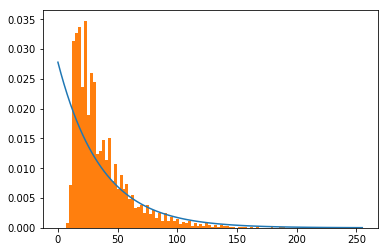

In [67]:
data = train_random_features[100, :10000]

exp_mean = data.mean()
x = np.linspace(0, data.max(), num=100)

plt.plot(x, expon.pdf(x, scale=exp_mean))

plt.hist(data, bins=100, normed=True)

In [12]:
random_mapping.opu._dmd_roi.dmd_shape

array([ 912, 1140])

In [ ]:
random_mapping.opu.device.cam_roi_increment

In [9]:
random_mapping.opu.device.exposure_us = 2000
random_mapping.opu.device.frametime_us = 2100

In [8]:
random_mapping.opu.device.cam_shape

[341, 384]

In [9]:
random_mapping.opu.close()

In [14]:
from lightonopu.opu import OPU

with OPU(n_components=1000) as opu_dev:

    random_mapping = OPUMap(opu=opu_dev, n_components=1000, ndims=1)
    random_mapping.opu.device.exposure_us = 900
    random_mapping.opu.device.frametime_us = 1000
    train_random_features = random_mapping.transform(train_data_bin)
    test_random_features = random_mapping.transform(test_data_bin)

In [39]:
np.save('opu_fashion_mnist_features/train_{}K.npy'.format(n_components//1000), train_random_features)

In [40]:
np.save('opu_fashion_mnist_features/test_{}K.npy'.format(n_components//1000), test_random_features)

In [47]:
np.hstack([np.array([1,2,3,4]).reshape((-1, 1)), np.array([1,2,3,4]).reshape((-1, 1))])

array([[1, 1],
       [2, 2],
       [3, 3],
       [4, 4]])

## Ridge Classifier

In [63]:
# Rescaled OPU: dim=1k
train_random_features = opu_features_400_train[:50000, :10000]
val_random_features = opu_features_400_train[50000:, :10000]
test_random_features = opu_features_400_test[:, :10000]
train_labels_sub = train_labels[:50000]
val_labels = train_labels[50000:]

In [27]:
clf = RidgeClassifier(alpha=1.0)
clf.fit(train_random_features, train_labels)
score = clf.score(test_random_features, test_labels)

In [28]:
# without rescaling
score

0.8775

In [30]:
factor

0.4014244259998856

In [37]:
raw_scale

0.0889688902844589

(array([ 11.,  24.,  21., 100.,   0.,  69.,  29.,  48.,  27.,  55.,  41.,
         26.,  46.,  21.,  38.,  19.,  29.,  11.,  36.,  12.,  20.,  25.,
         12.,  28.,  27.,  10.,  13.,  14.,   5.,  16.,  12.,   7.,  16.,
          2.,  10.,   1.,  13.,   5.,   6.,   5.,   8.,   6.,   1.,   8.,
          4.,   4.,   1.,   2.,   1.,   1.,   4.,   3.,   4.,   2.,   3.,
          4.,   2.,   3.,   2.,   1.,   1.,   1.,   1.,   0.,   3.,   2.,
          1.,   2.,   0.,   1.,   2.,   0.,   3.,   0.,   0.,   0.,   0.,
          0.,   1.,   2.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,
          1.]),
 array([  9.  ,  10.55,  12.1 ,  13.65,  15.2 ,  16.75,  18.3 ,  19.85,
         21.4 ,  22.95,  24.5 ,  26.05,  27.6 ,  29.15,  30.7 ,  32.25,
         33.8 ,  35.35,  36.9 ,  38.45,  40.  ,  41.55,  43.1 ,  44.65,
         46.2 ,  47.75,  49.3 ,  50.85,  52.4 ,  53.95,  55.5 ,  57.05,
         58.6 ,  60.15,  61.7 

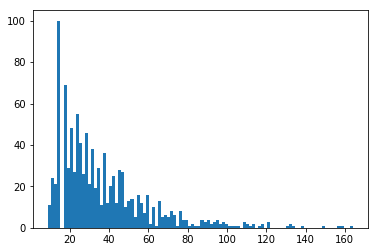

In [43]:
plt.hist(train_random_features[0, :1000], bins=100)

In [52]:
train_random_features.shape

(60000, 1000)

In [ ]:
train_labels

In [54]:
raw_scale

0.0889688902844589

In [56]:
train_random_features.shape

(50000, 1000)

In [57]:
train_labels.shape

(60000,)

In [69]:
factor = 0.001 / raw_scale

In [70]:
factor

0.011239883927996798

In [72]:
factor * np.dot(train_random_features[1], train_random_features[1])

2.787491214143206

In [ ]:
factor * train_random_features

In [65]:
# rescaled
for variance in [1, 0.1, 0.01, 0.001, 0.0001, 0.00001]:
    # variance = np.arange(0.01, 0.1, 0.01)

    # factor = 1./np.sqrt(784) / raw_scale
    factor = variance / raw_scale

    clf = RidgeClassifier(alpha=1.0)
    clf.fit(factor * train_random_features, train_labels_sub)
    score = clf.score(factor * val_random_features, val_labels)
    print(variance, score)

1 0.876
0.1 0.876
0.01 0.8761
0.001 0.8777
0.0001 0.8744
1e-05 0.8297


In [66]:
# alpha
for alpha in [0.1, 1, 10, 100]:
    # variance = np.arange(0.01, 0.1, 0.01)

    # factor = 1./np.sqrt(784) / raw_scale
    factor = 0.001 / raw_scale

    clf = RidgeClassifier(alpha=alpha)
    clf.fit(factor * train_random_features, train_labels_sub)
    score = clf.score(factor * val_random_features, val_labels)
    print(variance, score)

1e-05 0.8766
1e-05 0.8777
1e-05 0.8788
1e-05 0.8744


In [28]:
# OPU: dim=1K, std_dev=0.5, 32bits
since = time.time()

clf = RidgeClassifier(alpha=1.0)
clf.fit(train_random_features, train_labels)
score = clf.score(test_random_features, test_labels)

elapsed = time.time() - since

print('Score:', score)
print('Time:', elapsed)

Score: 0.8444
Time: 0.8923864364624023


In [11]:
# OPU: dim=10K, std_dev=0.5, 32bits
since = time.time()

clf = RidgeClassifier(alpha=1.0)
clf.fit(train_random_features, train_labels)
score = clf.score(test_random_features, test_labels)

elapsed = time.time() - since

print('Score:', score)
print('Time:', elapsed)

Score: 0.8773
Time: 35.18646216392517


In [41]:
# OPU: dim=20K, std_dev=0.5, 32bits
since = time.time()

clf = RidgeClassifier(alpha=1.0)
clf.fit(train_random_features, train_labels)
score = clf.score(test_random_features, test_labels)

elapsed = time.time() - since

print('Score:', score)
print('Time:', elapsed)

Score: 0.8671
Time: 130.62805652618408
